In [ ]:
# pip install pyLDAvis

In [1]:
import gensim
import nltk
import pandas as pd
import numpy as np
import re
import collections
import itertools
import warnings
# import pyLDAvis
# import pyLDAvis.gensim_models

from gensim import corpora
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from pprint import pprint

import matplotlib.pyplot as plt
import spacy
# from tmtoolkit.topicmod.tm_gensim import evaluate_topic_models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import pkg_resources
print(pkg_resources.get_distribution('gensim').version)
print(pkg_resources.get_distribution('nltk').version)
print(pkg_resources.get_distribution('pandas').version)
print(pkg_resources.get_distribution('spacy').version)
print(pkg_resources.get_distribution('pyLDAvis').version)
print(pkg_resources.get_distribution('wordcloud').version)
print(pkg_resources.get_distribution('matplotlib').version)


3.6.0
3.2.5
1.1.5
2.2.4


DistributionNotFound: ignored

In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
# stop_words.extend(['let', 'fig'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def measure_model(model):
  #perplexity
  print(model.log_perplexity(corpus_test))
  #coherence
  coherence_model_lda = CoherenceModel(model=model, texts=data_all_lemmatized, dictionary=id2word, coherence='c_v')
  print(coherence_model_lda.get_coherence())

In [5]:
def ShowWordCloud(data):
    string = ','.join(str(text) for text in data)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, regexp=r"\w[\w']+\w").generate(string)

    plt.figure(figsize=(30, 30))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)


def remove_stopwords_spacy(texts):
  filtered_texts = []
  for text in texts:
    filtered_sentence = [] 
    for word in text:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def remove_stopwords_nltk(texts):
  filtered_texts = []
  for doc in texts:
    filtered_sentence = []
    for word in gensim.utils.simple_preprocess(str(doc)):
      if word not in stop_words:
        filtered_sentence.append(word)
    filtered_texts.append(filtered_sentence)
  return filtered_texts

def twenty_newsgroup_to_list():
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
    data = {'texts': newsgroups_train.data, 'topic_names': newsgroups_train['target_names'], 'topics_assigned': newsgroups_train['target']}
    return data

def countWordsTotal(texts):
  total = 0
  for text in texts:
    total += len(text)
  return total

def remove_twosymbols(texts):
  for text in texts:
    for word in text:
      if len(word) <= 2:
        text.remove(word)
  return texts

def prepare_data(data, threshold):
  data_words = list(sent_to_words(data))
  # ShowWordCloud(data_words)

  print("Povodny text po tokenizacii, pocet slov:")
  print(countWordsTotal(data_words))
  print(data_words[0][:50])

  data_words_nostops = remove_stopwords_spacy(data_words)
  print("Pocet slov po vymazani stop-slov:")
  print(countWordsTotal(data_words_nostops))
  print(len(data_words_nostops[0]))
  print(data_words_nostops[0][:50])

  data_lemmatized = []
  for text in data_words_nostops:
    doc = nlp(" ".join(text))
    data_lemmatized.append([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])

  print("Pocet slov po lemmatizacii:")
  print(countWordsTotal(data_lemmatized))
  print(len(data_lemmatized[0]))
  print(data_lemmatized[0][:50])

  data_words_nostops = remove_stopwords_spacy(data_lemmatized)
  print("Pocet slov po opakovanom vymazani stop-slov:")
  print(countWordsTotal(data_words_nostops))
  print(len(data_words_nostops[0]))
  print(data_words_nostops[0][:50])

  bigram = gensim.models.Phrases(data_words_nostops, threshold=100)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  data_bigrams = [bigram_mod[text] for text in data_words_nostops]
  
  result = remove_twosymbols(data_bigrams)
  print("Pocet slov po vymazani dvojpismenkovych a menej slov:")
  print(countWordsTotal(result))
  print(len(result[0]))
  print(result[0][:50])
  
  return result

def clean_data(papers):
  papers = papers.drop(columns=['id', 'event_type', 'pdf_name', 'year', 'abstract'], axis=1)
  papers['paper_text_processed'] = papers['paper_text'].str.replace('[ \t\n\r\f\v]', " ")
  papers['paper_text_processed'] = papers['paper_text_processed'].str.replace(r"\S*@\S*\s?", "")
  papers['paper_text_processed'] = papers['paper_text_processed'].str.lower()
  return papers

In [6]:
papers_all = pd.read_csv('drive/MyDrive/Colab Notebooks/papers.csv')
papers_all = papers_all[:1600]
papers_all = clean_data(papers_all)
data_all_lemmatized = prepare_data(papers_all['paper_text_processed'].values, 100)
# ShowWordCloud(data_all_lemmatized)

Povodny text po tokenizacii, pocet slov:
4575810
['self', 'organization', 'of', 'associative', 'database', 'and', 'its', 'applications', 'hisashi', 'suzuki', 'and', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'an', 'efficient', 'method', 'of', 'self', 'organizing', 'associative', 'databases', 'is', 'proposed', 'together', 'with', 'applications', 'to', 'robot', 'eyesight', 'systems', 'the', 'proposed', 'databases', 'can', 'associate', 'any', 'input', 'with', 'some', 'output', 'in', 'the', 'first', 'half']
Pocet slov po vymazani stop-slov:
2627823
1681
['self', 'organization', 'associative', 'database', 'applications', 'hisashi', 'suzuki', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'efficient', 'method', 'self', 'organizing', 'associative', 'databases', 'proposed', 'applications', 'robot', 'eyesight', 'systems', 'proposed', 'databases', 'associate', 'input', 'output', 'half', 'discussion', 'algorithm', '

In [7]:
papers = papers_all[:int(2*len(papers_all)/3)]
data_lemmatized = data_all_lemmatized[:int(2*len(papers_all)/3)]
papers_test = papers_all[int(2*len(papers_all)/3):]
data_test_lemmatized = data_all_lemmatized[int(2*len(papers_all)/3):]

In [9]:
id2word = corpora.Dictionary(data_all_lemmatized)

print(len(id2word))
id2word.filter_extremes(no_above=0.5, no_below=5)
print(len(id2word))

corpus_all = [id2word.doc2bow(text) for text in data_all_lemmatized]
corpus_train = corpus_all[:int(2*len(papers_all)/3)]
corpus_test = corpus_all[int(2*len(papers_all)/3):]

31635
7802


## LDA Gensim

In [10]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto')
pprint(lda_model.print_topics())

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(0,
  '0.029*"image" + 0.014*"object" + 0.012*"visual" + 0.011*"response" + '
  '0.010*"cell" + 0.010*"filter" + 0.010*"spike" + 0.010*"stimulus" + '
  '0.009*"signal" + 0.009*"representation"'),
 (1,
  '0.012*"mixture" + 0.012*"gaussian" + 0.011*"cluster" + 0.010*"prior" + '
  '0.010*"density" + 0.009*"component" + 0.007*"posterior" + 0.007*"noise" + '
  '0.007*"source" + 0.006*"matrix"'),
 (2,
  '0.021*"bind" + 0.016*"bound" + 0.012*"theorem" + 0.008*"theory" + '
  '0.007*"approximation" + 0.006*"complexity" + 0.006*"risk" + 0.006*"optimal" '
  '+ 0.006*"generalization" + 0.006*"exist"'),
 (3,
  '0.023*"action" + 0.019*"policy" + 0.012*"agent" + 0.012*"control" + '
  '0.011*"reward" + 0.009*"optimal" + 0.009*"decision" + 0.008*"reinforcement" '
  '+ 0.007*"transition" + 0.006*"memory"'),
 (4,
  '0.023*"neuron" + 0.012*"cell" + 0.011*"circuit" + 0.010*"synaptic" + '
  '0.009*"connection" + 0.008*"voltage" + 0.007*"dynamic" + 0.007*"activity" + '
  '0.006*"chip" + 0.006*"rule"'),
 (5,

In [11]:
measure_model(lda_model)

-7.652921960242111
0.5363248485772067


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_all, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.159982 -0.002097       1        1  21.780277
5      0.059414  0.064249       2        1  17.007664
4     -0.036367 -0.060919       3        1  15.468084
2      0.074878  0.174928       4        1  15.009421
0     -0.190750 -0.176946       5        1  11.754440
3     -0.209482  0.149683       6        1  11.182448
6      0.142325 -0.148899       7        1   7.797667, topic_info=           Term          Freq         Total Category  logprob  loglift
198       image  46926.000000  46926.000000  Default  30.0000  30.0000
1272     object  24356.000000  24356.000000  Default  29.0000  29.0000
2847     policy  17730.000000  17730.000000  Default  28.0000  28.0000
657      action  17128.000000  17128.000000  Default  27.0000  27.0000
564      neuron  18314.000000  18314.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
902    gradient   3107.010462  17332.357311   Topic7  -5.0452   0.8324
1564       path   2313.251927   6336.980249   Topic7  -5.3402   1.5436
1446     update   2584.323537  13576.144494   Topic7  -5.2294   0.8925
1256  iteration   2575.464939  13858.319436   Topic7  -5.2329   0.8685
356      search   2215.007784  10158.895892   Topic7  -5.3836   1.0283

[494 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6679      7  0.998240  absorption
1013      1  0.119274    accuracy
1013      2  0.107432    accuracy
1013      3  0.163914    accuracy
1013      4  0.411733    accuracy
...     ...       ...         ...
438       4  0.727372        word
438       5  0.000785        word
438       6  0.005886        word
6004      2  0.090330      worker
6004      7  0.909666      worker

[1285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 3, 1, 4, 7])

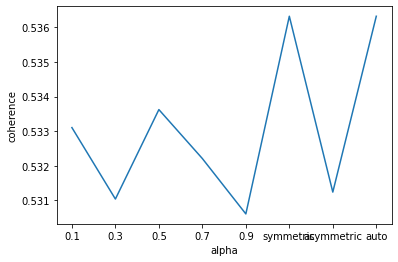

In [ ]:
ypoints = np.array([0.5331046600025047, 0.5310386660277494, 0.5336253020678526, 0.532209612989076, 0.5306085315954776, 0.5363248485772067, 0.5312397789134833, 0.5363248485772067])
xpoints = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 'symmetric', 'asymmetric', 'auto'])

plt.plot(xpoints, ypoints)
plt.xlabel("alpha")
plt.ylabel("coherence")
plt.show()

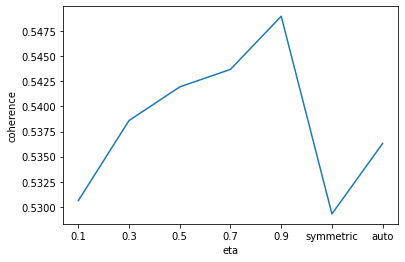

In [ ]:
ypoints = np.array([0.5306099402374206, 0.5385978488351121, 0.5419533597118711, 0.543700486008355, 0.5489961057289695, 0.5292918170297629, 0.5363248485772067])
xpoints = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 'symmetric', 'auto'])

plt.plot(xpoints, ypoints)
plt.xlabel("eta")
plt.ylabel("coherence")
plt.show()

### Custom hyperparameter tuning

In [ ]:
def hypertuning(corpus, texts, limit=19, start=3, step=2):
    model_results = {'num_topics': [],
                      'coherence': []
                      }

    for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=num_topics, 
                                              random_state=100,
                                              chunksize=100,
                                              passes=10,
                                              eta='auto',
                                              alpha='auto')
      coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
      coh = coherence_model.get_coherence()
      # perpl = model.log_perplexity(corpus_test)
      model_results['num_topics'].append(num_topics)
      model_results['coherence'].append(coh)
      print(coh)
    return model_results

In [ ]:
model_results = hypertuning(corpus_train, data_all_lemmatized)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


0.4393337600142453
0.5405414506143481
0.5357678943191416
0.5329909466027758
0.5321874144129155
0.5399703631304825
0.5630029461009844
0.5486768109662633


In [ ]:
best_res = max(model_results['coherence'])
i = model_results['coherence'].index(best_res)
best_topic = model_results['num_topics'][i]
for x in model_results:
  print(x)
  print(model_results[x][i])
best_topic

num_topics
15
coherence
0.5630029461009844


15

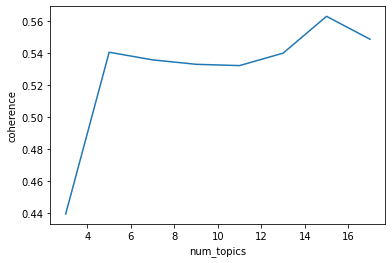

In [ ]:
plt.plot(model_results['num_topics'], model_results['coherence'])
plt.xlabel("num_topics")
plt.ylabel("coherence")
plt.show()

In [ ]:
# alpha = ['symmetric', 'asymmetric', 'auto']
# alpha_model_results = []
# for a in alpha:
#   model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
#                                               id2word=id2word,
#                                               num_topics=best_topic, 
#                                               random_state=100,
#                                               chunksize=100,
#                                               passes=10,
#                                               alpha=a,
#                                               eta='auto')
#   coherence_model = CoherenceModel(model=model, texts=data_all_lemmatized, dictionary=id2word, coherence='c_v')
#   coh = coherence_model.get_coherence()
#   alpha_model_results.append(coh)
#   print(coh)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


0.5363248485772067
0.5312397789134833
0.5363248485772067


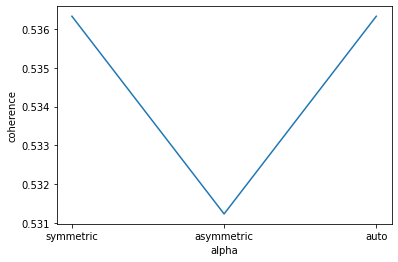

In [ ]:
# plt.plot(alpha, alpha_model_results)
# plt.xlabel("alpha")
# plt.ylabel("coherence")
# plt.show()

In [ ]:
eta = [0.1, 0.3, 0.5, 0.7, 0.9, 'symmetric', 'auto']
eta_model_results = []

for e in eta:
  model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                              id2word=id2word,
                                              num_topics=best_topic, 
                                              random_state=100,
                                              chunksize=100,
                                              passes=10,
                                              eta=e,
                                              alpha='auto')
  coherence_model = CoherenceModel(model=model, texts=data_all_lemmatized, dictionary=id2word, coherence='c_v')
  coh = coherence_model.get_coherence()
  eta_model_results.append(coh)
  print(coh)

0.5579002343616997
0.5653326556261344
0.5721168756869623
0.5510785898483931
0.552242984793603
0.551748677459635


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


0.5630029461009844


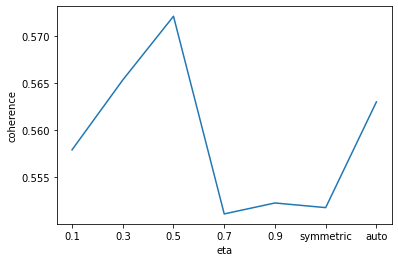

In [ ]:
plt.plot(eta, eta_model_results)
plt.xlabel("eta")
plt.ylabel("coherence")
plt.show()

In [ ]:
eta_best_res = max(eta_model_results)
i_eta = eta_model_results.index(eta_best_res)
best_eta = eta[i_eta]
best_eta

0.5

In [ ]:
best_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                              id2word=id2word,
                                              num_topics=best_topic, 
                                              random_state=100,
                                              chunksize=100,
                                              passes=10,
                                              alpha='auto',
                                              eta=best_eta)

In [ ]:
measure_model(best_model)

-7.657102546332366
0.5721168756869623


In [ ]:
pyLDAvis.enable_notebook()
vis_best = pyLDAvis.gensim_models.prepare(best_model, corpus_all, id2word)
vis_best

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.054374 -0.011384       1        1  24.238218
6     -0.097008 -0.060999       2        1  16.089213
0      0.165036 -0.020330       3        1  15.841857
4      0.144489  0.100467       4        1  14.780317
5      0.018112 -0.053481       5        1  11.875157
3     -0.032462 -0.091200       6        1   9.979054
2     -0.143795  0.136927       7        1   7.196184, topic_info=               Term         Freq        Total Category  logprob  loglift
202           image  7137.000000  7137.000000  Default  30.0000  30.0000
432            unit  5718.000000  5718.000000  Default  29.0000  29.0000
1343           bind  2848.000000  2848.000000  Default  28.0000  28.0000
576          neuron  4282.000000  4282.000000  Default  27.0000  27.0000
669          action  3045.000000  3045.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
89         converge   326.057976  1197.830988   Topic7  -5.5820   1.3304
641      stochastic   347.462790  1570.734262   Topic7  -5.5185   1.1230
559           layer   352.305698  3152.186558   Topic7  -5.5046   0.4403
246         machine   348.130961  3277.534084   Topic7  -5.5165   0.3894
77    computational   312.543125  1485.335263   Topic7  -5.6244   1.0730

[465 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6195      1  0.015180  abnormal
6195      2  0.865242  abnormal
6195      3  0.030359  abnormal
6195      4  0.030359  abnormal
6195      5  0.015180  abnormal
...     ...       ...       ...
451       3  0.013413      word
451       4  0.014226      word
451       5  0.787707      word
451       6  0.009755      word
451       7  0.009348      word

[2807 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 5, 6, 4, 3])

## LDA scipy

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            )
data_all_lemmatized_texts = [' '.join(doc) for doc in data_all_lemmatized]
data_lemmatized_texts = [' '.join(doc) for doc in data_lemmatized]
data_all_vectorized = vectorizer.fit_transform(data_all_lemmatized_texts)
data_train_vectorized = vectorizer.fit_transform(data_lemmatized_texts)

NameError: ignored

In [ ]:
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

In [ ]:
lda_scipy = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_scipy.fit_transform(data_all_vectorized)

print(lda_scipy)  # Model attributes

In [ ]:
lda_scipy.transform(data_vectorized[1])

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_components': [6, 8, 10, 12], # Maybe we can get away with fewer n_components (memory)
    'learning_decay': [0.75, 0.80, 0.85]
}

lda_search = GridSearchCV(lda_scipy,
                          n_jobs=-1,
                          param_grid=params)

lda_search.fit(data_train_vectorized)
best = lda_search.best_estimator_

results = pd.DataFrame(lda_search.cv_results_)

In [ ]:
print("Perplexity: ", lda_scipy.perplexity(data_vectorized))

## LDA mallet

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_train, num_topics=20, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

In [ ]:
import numpy as np
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [ ]:
pyLDAvis.enable_notebook()
converted_mallet = mallet_to_lda(ldamallet)
vis = pyLDAvis.gensim_models.prepare(converted_mallet, corpus_all, id2word)
vis

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_all_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
def compute_coherence_values(corpus, texts, limit=25, start=5, step=2):
    model_list = []
    model_results = {'num_topics': [],
                      'alpha': [],
                      'coherence': []
                      }
    alpha = list(np.arange(0.01, 1, 0.3))

    for num_topics in range(start, limit, step):
      for a in alpha:
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, alpha=a)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coh = coherence_model.get_coherence()
        model_results['num_topics'].append(num_topics)
        model_results['alpha'].append(a)
        model_results['coherence'].append(coh)
    return model_list, model_results

In [ ]:
model_list, model_results = compute_coherence_values(corpus_train, data_all_lemmatized)
model_results

In [ ]:
max_value = max(model_results['coherence'])
max_index = model_results['coherence'].index(max_value)
print(max_value)

a1 = {'num_topics': [], 'coherence': []} #alpha = 0.01
a2 = {'num_topics': [], 'coherence': []} #alpha = 0.31
a3 = {'num_topics': [], 'coherence': []} #alpha = 0.61
a4 = {'num_topics': [], 'coherence': []} #alpha = 0.91

for i in range (0,40):
  if model_results['alpha'][i] == 0.01:
    a1['num_topics'].append(model_results['num_topics'][i])
    a1['coherence'].append(model_results['coherence'][i])
  elif model_results['alpha'][i] == 0.31:
    a2['num_topics'].append(model_results['num_topics'][i])
    a2['coherence'].append(model_results['coherence'][i])
  elif model_results['alpha'][i] == 0.61:
    a3['num_topics'].append(model_results['num_topics'][i])
    a3['coherence'].append(model_results['coherence'][i])
  else:
    a4['num_topics'].append(model_results['num_topics'][i])
    a4['coherence'].append(model_results['coherence'][i])

plt.plot(a1['num_topics'], a1['coherence'])
plt.show()
plt.plot(a2['num_topics'], a2['coherence'])
plt.show()
plt.plot(a3['num_topics'], a3['coherence'])
plt.show()
plt.plot(a4['num_topics'], a4['coherence'])
plt.show()

print(model_results['coherence'][max_index])
print(model_results['num_topics'][max_index])
print(model_results['alpha'][max_index])